In [1]:
# Install required packages.
!pip install torch

import os
import torch
import numpy as np
from tqdm import tqdm 

os.environ['TORCH'] = torch.__version__
print(torch.__version__)

!pip install -q torch-scatter -f https://data.pyg.org/whl/torch-${TORCH}.html
!pip install -q torch-sparse -f https://data.pyg.org/whl/torch-${TORCH}.html
!pip install -q git+https://github.com/pyg-team/pytorch_geometric.git

Defaulting to user installation because normal site-packages is not writeable
2.5.1


In [2]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)


cpu


In [ ]:
# import torch
# import pickle
# from torch_geometric.datasets import TUDataset

# from google.colab import drive
# drive.mount('/content/drive')
# FOLDERNAME = 'cse493g1/project/data'
# assert FOLDERNAME is not None, "[!] Enter the foldername."

# %cd drive/My\ Drive

# dataset_path = os.path.join(FOLDERNAME, 'solutions_dataset_gnn_graphs.pkl')
# with open(dataset_path, 'rb') as f:
#     dataset = pickle.load(f)

from construct_dataset import SolutionDataset

dataset = SolutionDataset(root='../edges')

In [4]:
print()
print(f'Dataset: {dataset}:')
print('====================')
print(f'Number of graphs: {len(dataset)}')
print(f'Number of features: {dataset.num_features}')
# print(f'Number of classes: {dataset.num_classes}')



Dataset: SolutionDataset(319120):
Number of graphs: 319120
Number of features: 194


In [5]:
def printstats(index):
    data = dataset[index]  

    print()
    print(data)
    print('=============================================================')
    print(f'Number of nodes: {data.num_nodes}')
    print(f'Number of edges: {data.num_edges}')
    print(f'Average node degree: {data.num_edges / data.num_nodes:.2f}')
    print(f'Has isolated nodes: {data.has_isolated_nodes()}')
    print(f'Has self-loops: {data.has_self_loops()}')
    print(f'Is undirected: {data.is_undirected()}')
    print('=============================================================')
    print(f'Data.x: {data.x}')
    print(f'Data.y: {data.y}')

    return (data.x, data.y)

In [6]:
x1, y1 = printstats(0)
x2, y2 = printstats(-1)


Data(edge_index=[2, 717], name=[718], num_nodes=718, x=[718, 194], y=0)
Number of nodes: 718
Number of edges: 717
Average node degree: 1.00
Has isolated nodes: False
Has self-loops: False
Is undirected: False
Data.x: tensor([[ 1.1583e+01,  1.8985e-01,  1.1228e-02,  ..., -1.3974e-01,
         -1.3974e-01, -1.3974e-01],
        [ 6.7340e-01,  1.2362e+01, -1.4642e-01,  ..., -1.4642e-01,
         -1.4642e-01, -1.4642e-01],
        [-1.0237e-01,  2.3053e-02, -1.0237e-01,  ..., -1.0237e-01,
         -1.0237e-01, -1.0237e-01],
        ...,
        [-1.4363e-01, -1.5694e-01, -1.5694e-01,  ..., -1.5481e-01,
         -1.5481e-01, -1.5694e-01],
        [-9.7487e-02, -9.7487e-02, -9.7487e-02,  ..., -9.7487e-02,
         -9.7487e-02, -9.7487e-02],
        [-1.0291e-01, -1.0291e-01, -1.0291e-01,  ..., -1.0291e-01,
         -1.0291e-01, -1.0291e-01]])
Data.y: 0

Data(edge_index=[2, 753], name=[754], num_nodes=754, x=[754, 194], y=2525)
Number of nodes: 754
Number of edges: 753
Average node degree: 1

In [7]:
NODE_FEATURES = dataset.num_features
NUM_CLASSES = dataset[-1].y.item() + 1

print(NODE_FEATURES)
print(NUM_CLASSES)


194
2526


In [ ]:
### RUN THIS ONLY IF TRAIN/TEST TENSORS HAVE NOT YET BEEN SAVED TO DISK ###

# When saving, store the complete Data objects
import torch
import os

CHUNK_SIZE = 25000 # adjust based on available memory
train_data_list = []
test_data_list = []
num_items = len(dataset)

for i in range(num_items):
    data = dataset.get(i)  # each data is a full PyG Data object
    if (i + 1) % 10 == 0:
        test_data_list.append(data)
    else:
        train_data_list.append(data)
    
    # Save chunks when the chunk size is reached
    if (i + 1) % CHUNK_SIZE == 0:
        chunk_idx = (i + 1) // CHUNK_SIZE
        
        train_filename = f'train/chunk_{chunk_idx}.pt'
        torch.save(train_data_list, train_filename)
        print(f'Saved {len(train_data_list)} training samples to {train_filename}')
        
        test_filename = f'test/chunk_{chunk_idx}.pt'
        torch.save(test_data_list, test_filename)
        print(f'Saved {len(test_data_list)} test samples to {test_filename}')
        
        train_data_list, test_data_list = [], []

# Save any remaining samples
if train_data_list or test_data_list:
    chunk_idx = (num_items // CHUNK_SIZE) + 1
    train_filename = f'train/chunk_{chunk_idx}.pt'
    torch.save(train_data_list, train_filename)
    print(f'Saved {len(train_data_list)} training samples to {train_filename}')
    
    test_filename = f'test/chunk_{chunk_idx}.pt'
    torch.save(test_data_list, test_filename)
    print(f'Saved {len(test_data_list)} test samples to {test_filename}')

In [8]:
from torch_geometric.data import Dataset
from torch_geometric.loader import DataLoader

class LazyGraphDataset(Dataset):
    def __init__(self, chunk_dir, transform=None):
        """
        Args:
            chunk_dir (str): Directory where chunk files are stored.
        """
        super().__init__(None, transform, None)
        # List all chunk files in the given directory
        self.chunk_files = sorted([
            os.path.join(chunk_dir, f) for f in os.listdir(chunk_dir)
            if f.endswith('.pt')
        ])
        # Build cumulative sizes to map a global index to a chunk file and local index.
        self.cum_sizes = []
        total = 0
        self.samples_per_chunk = []
        for file in self.chunk_files:
            data_list = torch.load(file, weights_only=False)
            count = len(data_list)
            self.samples_per_chunk.append(count)
            total += count
            self.cum_sizes.append(total)
        self.total_samples = total

        # Simple cache to avoid reloading the same chunk repeatedly.
        self._cache_file = None
        self._cache_data = None

    def len(self):
        return self.total_samples
    
    def get(self, idx):
        # Determine which chunk file holds the sample at global index idx.
        chunk_idx = 0
        for i, cum_size in enumerate(self.cum_sizes):
            if idx < cum_size:
                chunk_idx = i
                break
        local_idx = idx if chunk_idx == 0 else idx - self.cum_sizes[chunk_idx - 1]

        current_file = self.chunk_files[chunk_idx]
        if self._cache_file == current_file:
            data_list = self._cache_data
        else:
            data_list = torch.load(current_file, weights_only=False)
            self._cache_file = current_file
            self._cache_data = data_list

        data = data_list[local_idx]

        # If the graph is empty, add a dummy node and mark the graph as dummy.
        if data.x is None or data.x.size(0) == 0:
            data.x = torch.zeros((1, NODE_FEATURES), dtype=torch.float)
            data.edge_index = torch.empty((2, 0), dtype=torch.long)
            # Use an invalid label (for example, -1) or any placeholder
            data.y = torch.tensor(-1, dtype=torch.long)
            data.is_dummy = torch.tensor(1, dtype=torch.long)
        else:
            data.is_dummy = torch.tensor(0, dtype=torch.long)
        
        # Ensure that every Data object has a "name" attribute.
        # If missing, add it with a default value (e.g., an empty string).
        if not hasattr(data, 'name'):
            data.name = ""
        
        return data

# Create lazy datasets for training and testing
train_dataset = LazyGraphDataset(chunk_dir='train')
test_dataset = LazyGraphDataset(chunk_dir='test')

In [ ]:
# Create DataLoaders that load batches on the fly.
train_loader = DataLoader(train_dataset, batch_size=16, shuffle=False, num_workers=0)
test_loader = DataLoader(test_dataset, batch_size=1, shuffle=False, num_workers=0)

In [10]:
### HYPERPARAMETERS ###
HIDDEN_SIZE = 16384
LR = 1e-5
EPOCHS = 1

In [11]:
from torch.nn import Linear
import torch.nn.functional as F
from torch_geometric.nn import GCNConv
from torch_geometric.nn import global_mean_pool

class GCN(torch.nn.Module):
    def __init__(self, hidden_channels):
        super(GCN, self).__init__()
        self.conv1 = GCNConv(NODE_FEATURES, hidden_channels)
        self.conv2 = GCNConv(hidden_channels, hidden_channels)
        self.conv3 = GCNConv(hidden_channels, hidden_channels)
        self.lin = Linear(hidden_channels, NUM_CLASSES)

    def forward(self, x, edge_index, batch):
        # Ensure edge_index is an integer tensor
        edge_index = edge_index.long()
        
        x = self.conv1(x, edge_index)
        x = x.relu()
        x = self.conv2(x, edge_index)
        x = x.relu()
        x = self.conv3(x, edge_index)
        x = x.relu()

        x = global_mean_pool(x, batch)  
        
        x = F.dropout(x, p=0.5, training=self.training)
        x = self.lin(x)
        return x


model = GCN(hidden_channels=HIDDEN_SIZE).to(device) 
print(model)

GCN(
  (conv1): GCNConv(194, 16384)
  (conv2): GCNConv(16384, 16384)
  (conv3): GCNConv(16384, 16384)
  (lin): Linear(in_features=16384, out_features=2526, bias=True)
)


In [ ]:
from torch_geometric.data import Batch

optimizer = torch.optim.Adam(model.parameters(), lr=LR)
criterion = torch.nn.CrossEntropyLoss()

epoch_losses = {}
epoch_accuracies = {}

model.train()
for epoch in range(EPOCHS):
    epoch_loss = 0
    correct = 0
    total = 0
    
    for batch in tqdm(train_loader, desc=f"Epoch {epoch+1}/{EPOCHS} Progress"):
        # Convert batch to a list of Data objects.
        data_list = batch.to_data_list()
        # Filter out dummy graphs.
        filtered_data_list = [d for d in data_list if d.is_dummy.item() == 0]
        if len(filtered_data_list) == 0:
            print("Warning: entire batch is dummy, skipping")
            continue
        # Re-collate into a new Batch object.
        filtered_batch = Batch.from_data_list(filtered_data_list)
        filtered_batch = filtered_batch.to(device)

        batch = filtered_batch

        batch = batch.to(device)
        optimizer.zero_grad()
        
        # Forward pass: output shape should be (B, NUM_CLASSES)
        out = model(batch.x, batch.edge_index, batch.batch)
        
        yTrue = batch.y
        loss = criterion(out, yTrue)
        loss.backward()
        optimizer.step()
        
        epoch_loss += loss.item()
        
        # Compute predictions for the batch
        predictions = torch.argmax(out, dim=1)
        correct += (predictions == yTrue).sum().item()
        total += yTrue.size(0)
    
    epoch_accuracy = correct / total
    epoch_losses[epoch + 1] = epoch_loss
    epoch_accuracies[epoch + 1] = epoch_accuracy
    
    print(f"Epoch {epoch+1}/{EPOCHS}, Loss: {epoch_loss:.4f}, Correct: {correct}, Total: {total}, Accuracy: {epoch_accuracy:.4f}")

print("Training completed.")

Epoch 1/1 Progress:   0%|          | 2/8976 [00:42<52:09:53, 20.93s/it]

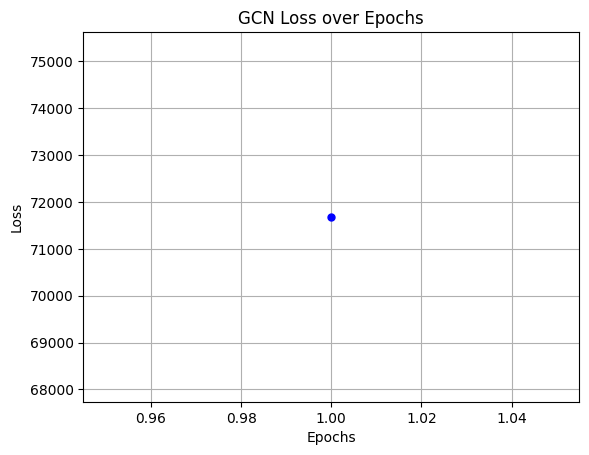

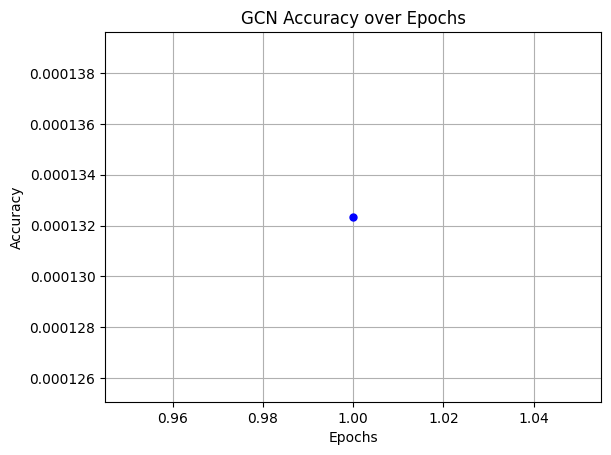

In [78]:
import matplotlib.pyplot as plt

epochs = list(epoch_losses.keys())
losses = list(epoch_losses.values())
accuracies = list(epoch_accuracies.values())

plt.plot(epochs, losses, marker='o', color='b', linestyle='-', markersize=5)
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('GCN Loss over Epochs')
plt.grid(True)
plt.show()

plt.plot(epochs, accuracies, marker='o', color='b', linestyle='-', markersize=5)
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('GCN Accuracy over Epochs')
plt.grid(True)
plt.show()

In [81]:
MODEL_PATH = "out/leetvision_classifier_1.pth"

In [83]:
torch.save(model, MODEL_PATH)

In [84]:
loaded_model = torch.load(MODEL_PATH)
loaded_model.eval()

/var/folders/qj/2t6cj_5121l_30dkf9rwfbvw0000gn/T/ipykernel_55420/1538415150.py:1: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  loaded_model = torch.load(MODEL_PATH)


GCN(
  (conv1): GCNConv(194, 1024)
  (conv2): GCNConv(1024, 1024)
  (conv3): GCNConv(1024, 1024)
  (lin): Linear(in_features=1024, out_features=2526, bias=True)
)

Testing Progress: 100%|██████████| 31912/31912 [01:49<00:00, 291.16it/s]


Top-1 Test Accuracy: 0.04% (12/31904)


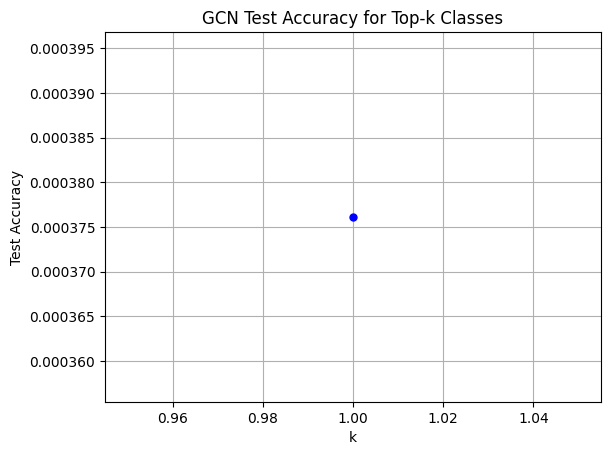

In [87]:
from matplotlib import pyplot as plt

def test(model, test_loader, k=1):
    model.eval()  # Set model to evaluation mode
    correct = 0
    total = 0
    with torch.no_grad():
        for batch in tqdm(test_loader, desc="Testing Progress"):
            # (Optional) Filter out dummy graphs if present:
            data_list = batch.to_data_list()
            filtered_data_list = [d for d in data_list if getattr(d, "is_dummy", 0) == 0]
            if len(filtered_data_list) == 0:
                continue  # Skip this batch if all graphs are dummy
            # Re-collate the filtered list:
            filtered_batch = Batch.from_data_list(filtered_data_list).to(device)
            
            # Forward pass: out shape: (batch_size, NUM_CLASSES)
            out = model(filtered_batch.x, filtered_batch.edge_index, filtered_batch.batch)
            # Get top-k predictions: shape: (batch_size, k)
            _, topk_indices = torch.topk(out, k, dim=1)
            
            # If labels are stored as graph-level indices, they should be 1D.
            if filtered_batch.y.dim() == 1:
                true_classes = filtered_batch.y
            else:
                true_classes = torch.argmax(filtered_batch.y.float(), dim=1)
            
            # Check per sample if the true class is in the top k predictions.
            correct_batch = (topk_indices == true_classes.unsqueeze(1)).any(dim=1)
            correct += correct_batch.sum().item()
            total += true_classes.size(0)
        
    return correct, total, correct / total

# Compute top-1 test accuracies
test_accuracies = {}
for k in range(1):
    correct, total, test_accuracy = test(loaded_model, test_loader, k + 1)
    test_accuracies[k + 1] = test_accuracy
    print(f"Top-{k + 1} Test Accuracy: {test_accuracy * 100:.2f}% ({correct}/{total})")

# Plot test accuracies
ks = list(test_accuracies.keys())
test_accuracy_mappings = list(test_accuracies.values())

plt.plot(ks, test_accuracy_mappings, marker='o', color='b', linestyle='-', markersize=5)
plt.xlabel('k')
plt.ylabel('Test Accuracy')
plt.title('GCN Test Accuracy for Top-k Classes')
plt.grid(True)
plt.show()

In [ ]:
from sklearn.decomposition import PCA
from constants import *
NUM_SOLUTIONS = 50

def plot_classifications(classes, k, best=False):
    outputs = []
    labels = []
    bottom_k_labels = []
    i = 0

    sorted_classes = sorted(classes.items(), key=lambda item: item[1][0])
    if best:
        sorted_classes = reversed(sorted_classes)

    for c, entry in sorted_classes:
        if i == k:
            break
        bottom_k_labels.append(c)
        for e in entry[1]:
            outputs.append(e)
            labels.append(c)
        i +=1

    # Concatenate all outputs and labels
    outputs = torch.cat(outputs, dim=0)  # Shape: (num_samples, num_classes)

    # Apply PCA to reduce dimensionality to 2D
    pca = PCA(n_components=2)
    outputs_2d = pca.fit_transform(outputs.numpy())  # Shape: (num_samples, 2)

    # Plot the PCA-transformed outputs
    plt.figure(figsize=(12, 8))

    label_to_index = {label: idx for idx, label in enumerate(bottom_k_labels)}
    indices = np.array([label_to_index[label] for label in labels])

    cmap = plt.cm.get_cmap('nipy_spectral', k)
    plt.scatter(outputs_2d[:, 0], outputs_2d[:, 1], c=indices, cmap=cmap, alpha=0.7)

    # Create a legend mapping colors to class labels
    handles = []
    for idx, label in enumerate(bottom_k_labels):
        color = cmap(idx)
        handles.append(plt.Line2D([], [], marker='o', color=color, linestyle='None',
                                markersize=10, label=f'{QUESTIONS[label]} ({(classes[label][0] / NUM_SOLUTIONS) * 100:.0f}%)'))
    plt.legend(handles=handles, title='Problems', bbox_to_anchor=(1.05, 1), loc='upper left')

    # Add plot titles and labels
    plt.title(f'Top k = {k} most {"accurately" if best else "poorly"} classified problems')
    plt.xlabel('Principal Component 1')
    plt.ylabel('Principal Component 2')
    plt.grid(True)
    plt.show()

In [ ]:
def plot_problem_accuracies(classes):
    sorted_classes = sorted(classes.items(), key=lambda item: item[1][0])

    problems = []
    accuracies = []
    for c, entry in sorted_classes:
        problems.append(QUESTIONS[c])
        accuracies.append(entry[0] / NUM_SOLUTIONS)

    # Create the bar chart
    plt.figure(figsize=(12, 8))
    plt.bar(problems, accuracies, color='skyblue')

    # Add labels and title
    plt.ylabel('Classification accuracy')
    plt.title('Problem classification accuracy')

    plt.xticks(problems, rotation=60, fontsize=7, ha='right')
    plt.yticks(np.arange(0, 1.1, 0.1))

    # Add gridlines for better readability
    plt.grid(axis='y', linestyle='--', alpha=0.7)

    mean_accuracy = sum(accuracies) / len(sorted_classes)
    plt.axhline(y=mean_accuracy, color='red', linestyle='-', linewidth=1)

    # Show the plot
    plt.tight_layout()
    plt.show()

In [19]:
import matplotlib.cm as cm
import matplotlib.colors as mcolors

# plots the top k classifications for the n worst performing problems
def plot_misclassifications(classes, n=10, k=5):
    sorted_classes = sorted(classes.items(), key=lambda item: item[1][0])
    
    problems = {}

    i = 0
    for c, entry in sorted_classes:
        if i == n:
            break
        wrong_problems = []

        counts = {}
        for output in entry[1]:
            max_idx = torch.argmax(output).item()
            if max_idx not in counts:
                counts[max_idx] = 0
            counts[max_idx] += 1

        # del counts[c] # delete correct classification
        counts = list(reversed(sorted(counts.items(), key=lambda item: item[1])))
        # counts = counts[:k]

        total = 0
        for count in counts:
            total += count[1]
        
        rem = total
        j = 0
        for idx, count in counts:
            if j == k:
                break
            wrong_problems.append((idx, count / total))
            rem -= count
            j += 1
        
        if rem > 0:
            wrong_problems.append((-1, rem / total))

        problems[c] = wrong_problems
        i += 1

    cmap = cm.get_cmap("autumn")
    categories = {cat for pie in problems.values() for cat, _ in pie}  # Unique categories
    norm = mcolors.Normalize(vmin=0, vmax=len(categories))
    category_to_color = {category: cmap(norm(idx)) for idx, category in enumerate(sorted(categories))}

    num_charts = len(problems)
    cols = 5  # Number of columns
    rows = (num_charts + cols - 1) // cols

    # Create a figure and axes for each pie chart
    _, axes = plt.subplots(rows, cols, figsize=(30, 30), constrained_layout=True)

    axes = axes.flatten()

    # If there's only one chart, make `axes` iterable
    if len(problems) == 1:
        axes = [axes]

    # Loop through the dictionary to create each pie chart
    for ax, (chart_name, categories) in zip(axes, problems.items()):
        # Extract names and percentages
        names, percentages = zip(*categories)

        colors = []
        for name in names:
            if name != chart_name:
                colors.append(category_to_color[name])
            else:
                colors.append('lightgreen')

        names = [FILES[j] if j != -1 else 'other' for j in names]
        
        # Create the pie chart
        wedges, _, autotexts = ax.pie(percentages, startangle=90, radius=1.0, colors=colors, autopct=custom_autopct)
        ax.set_title(FILES[chart_name], fontsize=10)

        # Add a legend mapping colors to names
        ax.legend(wedges, names, loc="center left", bbox_to_anchor=(1, 0.5),
              fontsize='small', markerscale=0.7, labelspacing=0.3)
        
        # Make the percentages smaller
        for autotext in autotexts:
            autotext.set_fontsize(8)  # Set smaller font size for percentages

    # Hide any extra subplot axes
    for ax in axes[num_charts:]:
        ax.axis('off')

    # Adjust layout to prevent overlapping
    plt.suptitle(f'Top classifications for the {n} most poorly classified problems\n')
    plt.show()

def custom_autopct(pct):
    return f"{pct:.1f}%" if pct > 5 else ""

/tmp/ipykernel_12827/1899681343.py:37: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = plt.cm.get_cmap('nipy_spectral', k)


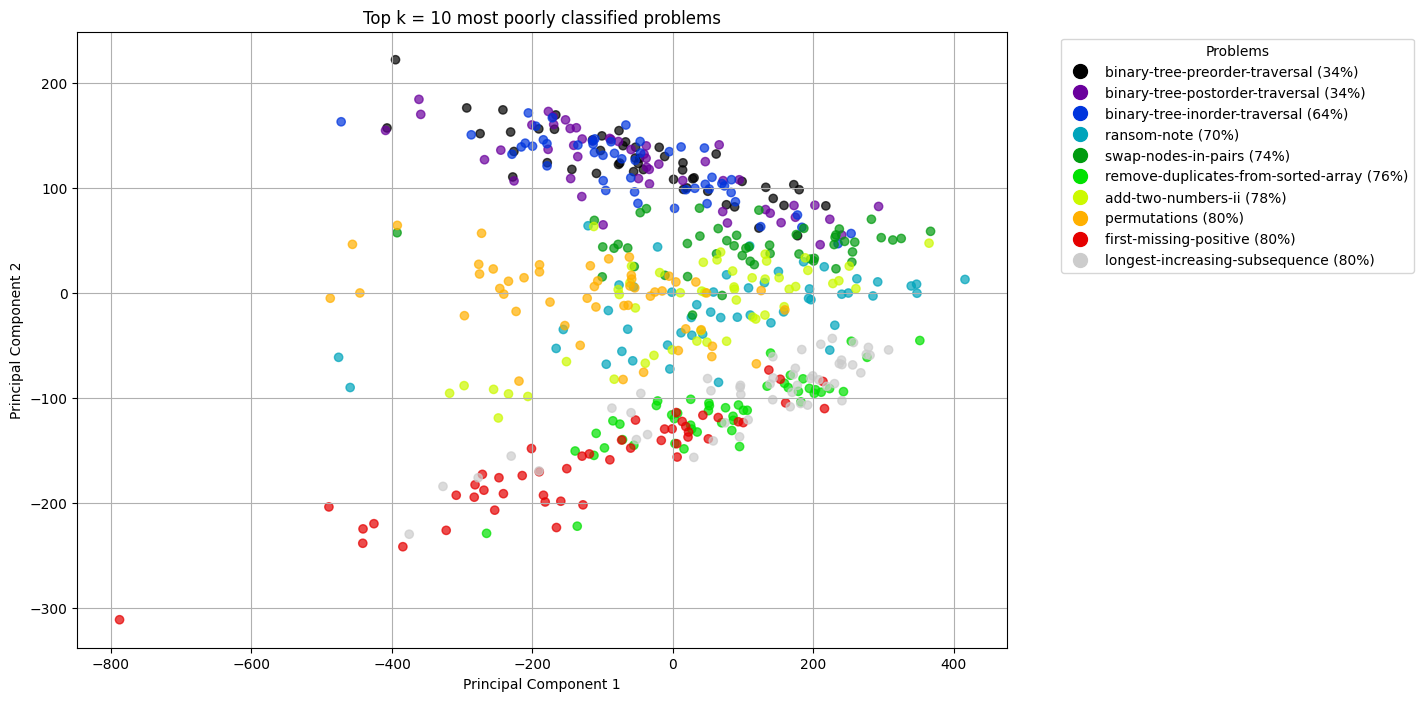

/tmp/ipykernel_12827/1899681343.py:37: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = plt.cm.get_cmap('nipy_spectral', k)


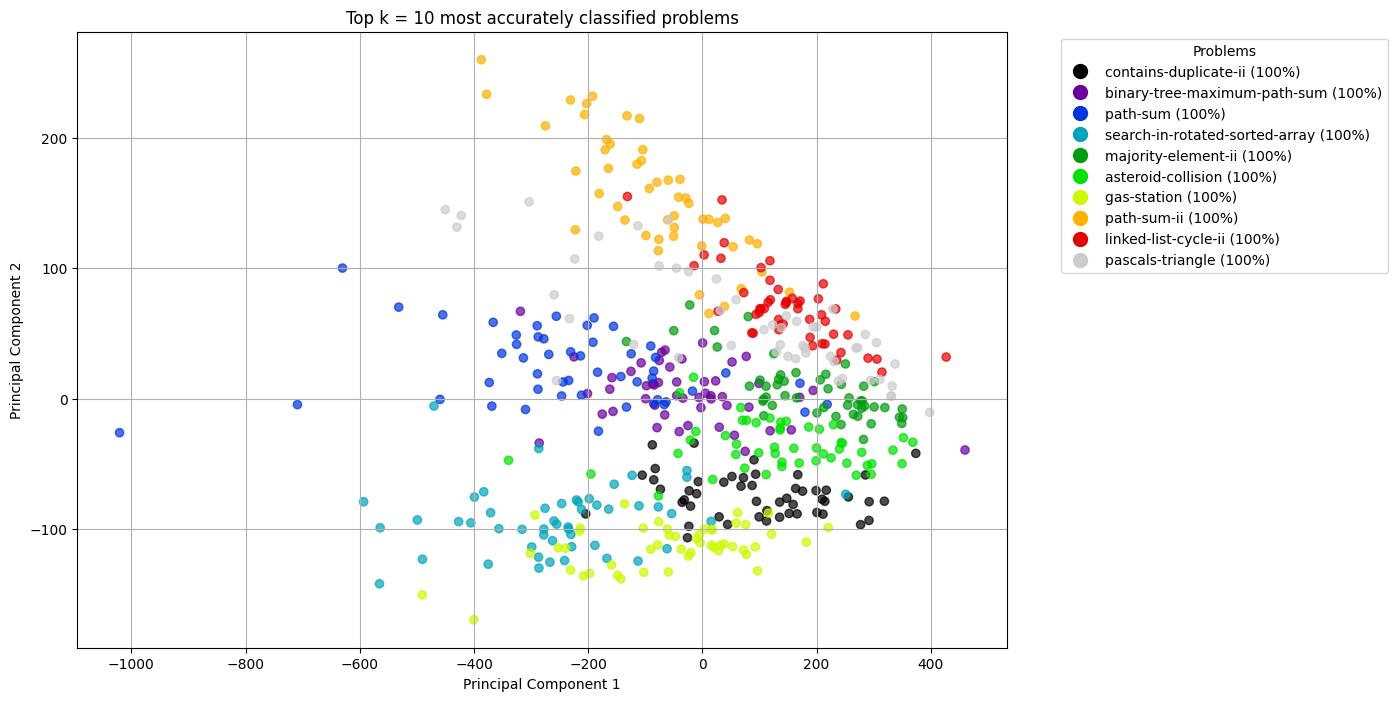

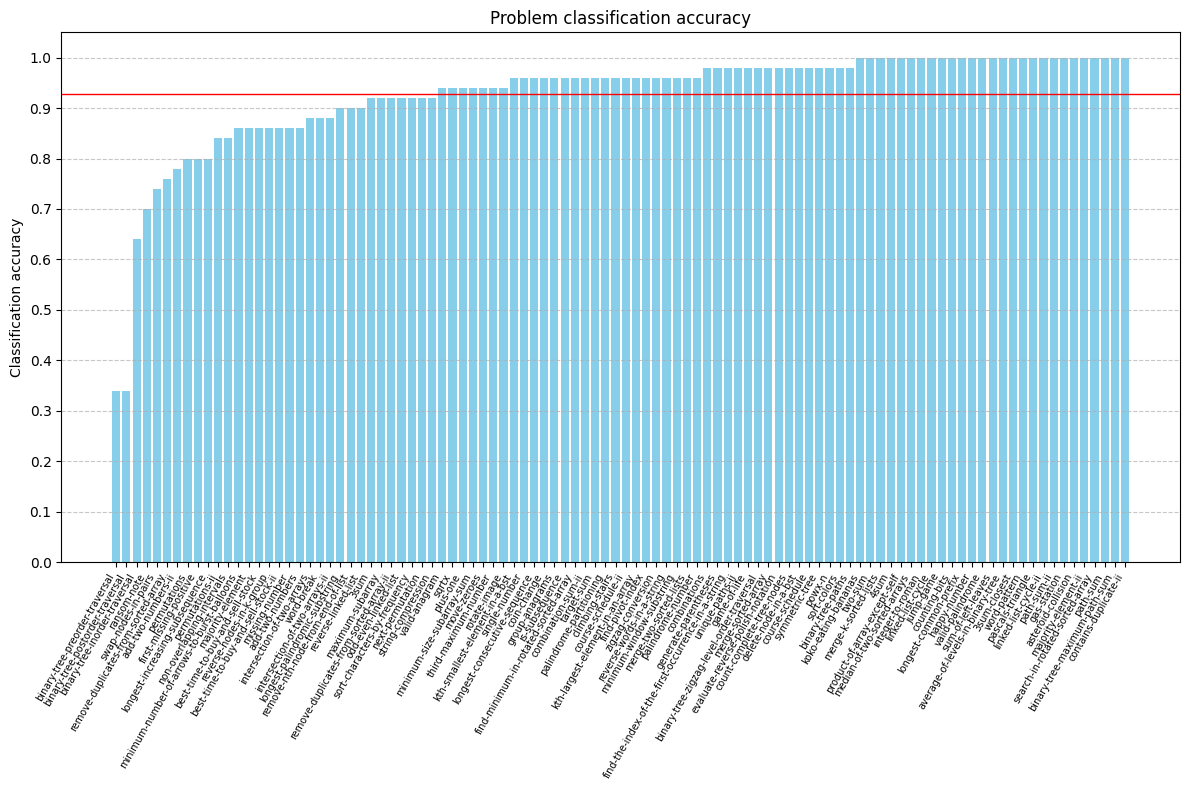

/tmp/ipykernel_12827/2985075944.py:46: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = cm.get_cmap("autumn")


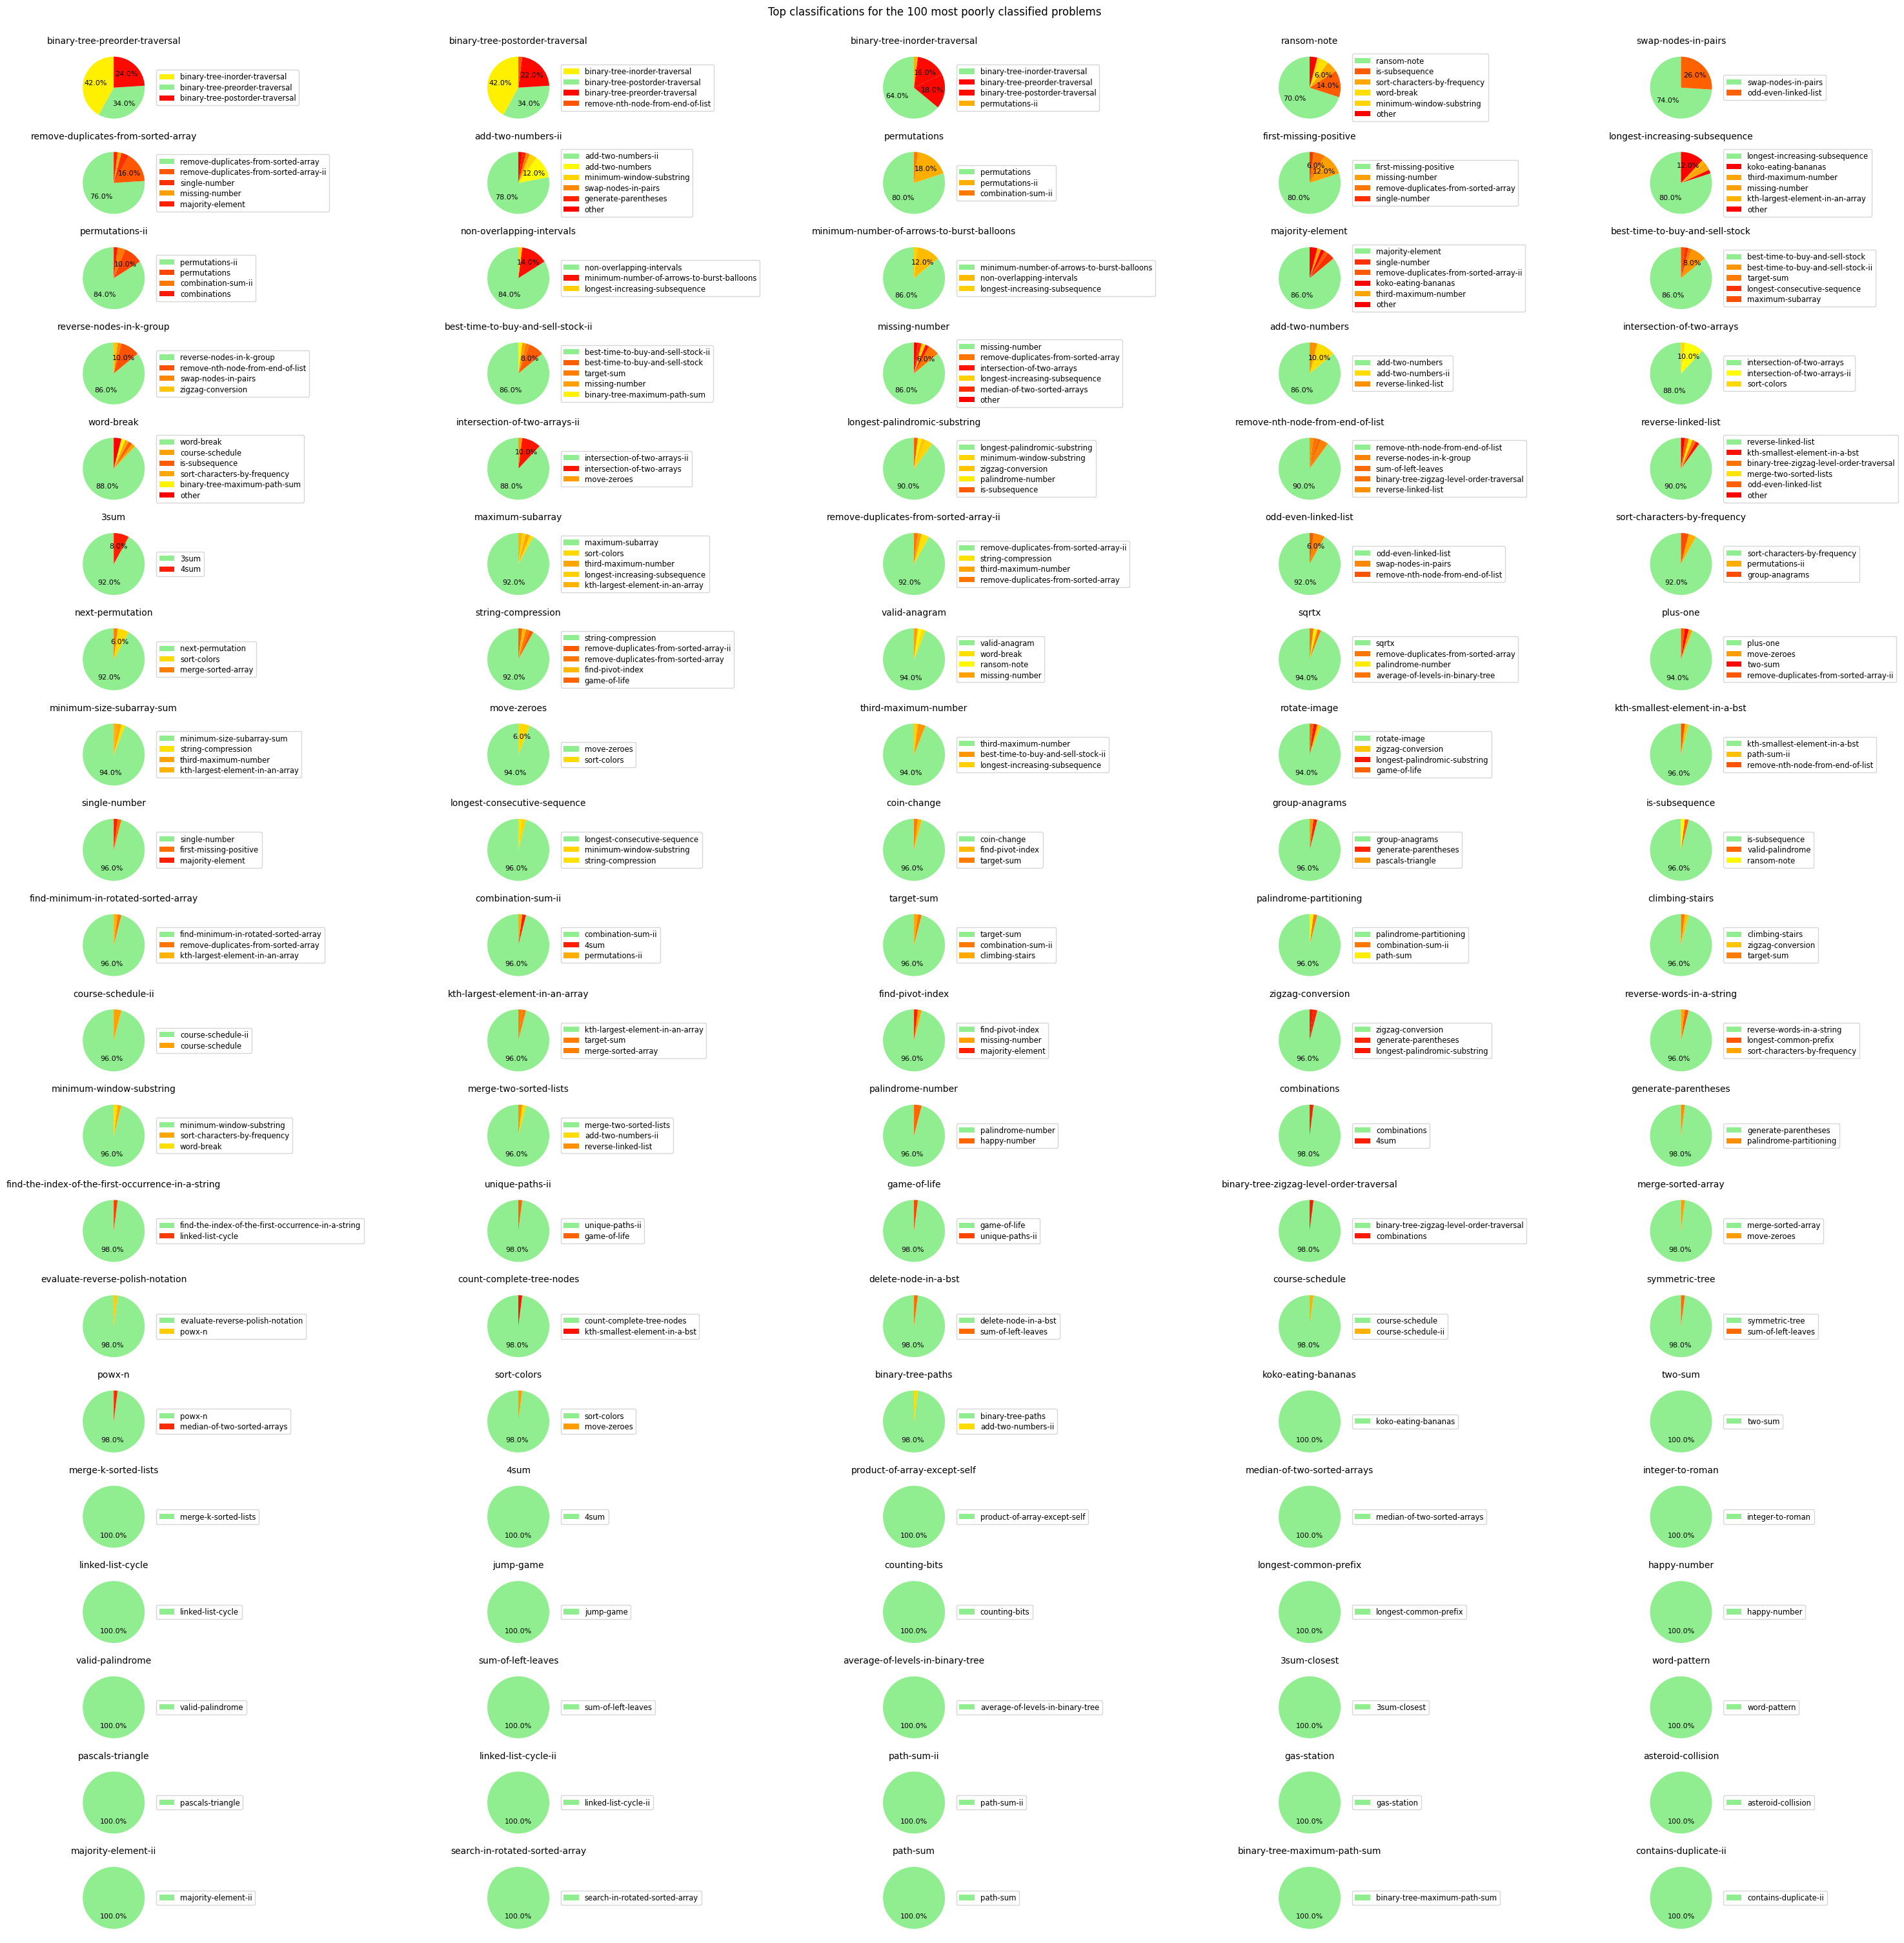

In [20]:
loaded_model.eval()  # Set model to evaluation mode

classes = {}
for i in range (NUM_CLASSES):
    classes[i] = (0, [])

with torch.no_grad():
    for batch in tqdm(test_loader, desc="Collecting Outputs"):
        batch = batch.to(device)
        out = loaded_model(batch.x, batch.edge_index, batch.batch)  # Shape: (batch_size, num_classes)
        max_idx = torch.argmax(out).item()
        actual_idx = torch.argmax(batch.y.float().reshape(1, NUM_CLASSES)).item()
        
        correct = 1 if max_idx == actual_idx else 0
        total_correct, class_outputs = classes[actual_idx]
        total_correct += correct
        class_outputs.append(out.cpu())
        classes[actual_idx] = (total_correct, class_outputs)

plot_classifications(classes, k=10)
plot_classifications(classes, k=10, best=True)
plot_problem_accuracies(classes)
plot_misclassifications(classes, n=100, k=5)